# Deep Learning for Seismic Fault interpretation
Reflection Seismic is a geophysical method used for subsurface exploration in the oil and gas industry. This method is based on the analysis of seismic waves recorded after these has traveled trough the subsurface rocks.

Part of the key information preovided for this method is the location of geological faults, which are zones were the rocks has been broken and displaced. The identification of the faults is a key taks because these can related to hydrocarbon acumulations, and also becaouse the faults can be associated to hazards for the drilling operations.

However the fault interpretation, is a complex task, wich relies on the interpreter experience and consumes a lot of time.

The goal for this project is to automatize the fault interpretation process, to save time and reduce the subjectivity of this process.

The data fro this project is from the Force-2020-Machine-Learning-competition at this link:

https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition

In addition, for this project I create this GitHub repository:

https://github.com/edmon2017/SeismicFault


In [2]:
import segyio
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

The first step is to import the data, seismic information is recorded in a format called SEGY, so I need to cretate a function to read this format and converted into an 3D array, for this step I'm going to use the library SEGYIO.
Then, I used that function to read two volumes: one with seismic data and another with fault labels

In [3]:
def load_segy_volume(path):
    with segyio.open(path, "r") as f:
        f.mmap()
        data = segyio.tools.cube(f)
    return data

In [8]:
# SEG-Y path
path_seismic = "issap20_Pp.sgy"
path_labels = "issap20_Fault.sgy"
seismic_vol = load_segy_volume(path_seismic)
label_vol = load_segy_volume(path_labels)

In [88]:
seismic_vol.shape

(101, 589, 751)

The size of this array correspond to the configuration of the seiscmic file, where the two first indices correspond to the surface coordinates of the samples (101 Inlines and 589 xlines) and the last indices correspond to the time samples (751 samples).

## Exploratory Data Analysis

To perform the EDA it is necesary to display the seismic information, to inspect the data and to realize a visual QC. For this step I create a function to display the seismic data

In [9]:
def plotseismic(seismicdata, iline_idx,title):
  inline_data = seismicdata[iline_idx, :, :]

  plt.figure(figsize=(10, 6))
  plt.imshow(inline_data.T, cmap='gray', aspect='auto', interpolation='none')
  plt.title(f'{title} Inline {iline_idx}')
  plt.xlabel('Xline')
  plt.ylabel('Time (ms)')
  plt.colorbar(label='Amplitude')
  plt.show()

Next is an example of an inline, we can observed both volumes, the seismic amplitude and fault labels.
For the first volume I can observed there are not missing traces, and there is data for the entire time window.
For the second volume I can observe the data correspond to the same range on xlines and to same time window, in addtion we can onbserve the fault position is indicated with a value of 1 and 0 where there are not faults.
After this inspection of the data I can conclude the data is ok and ready to be used.  

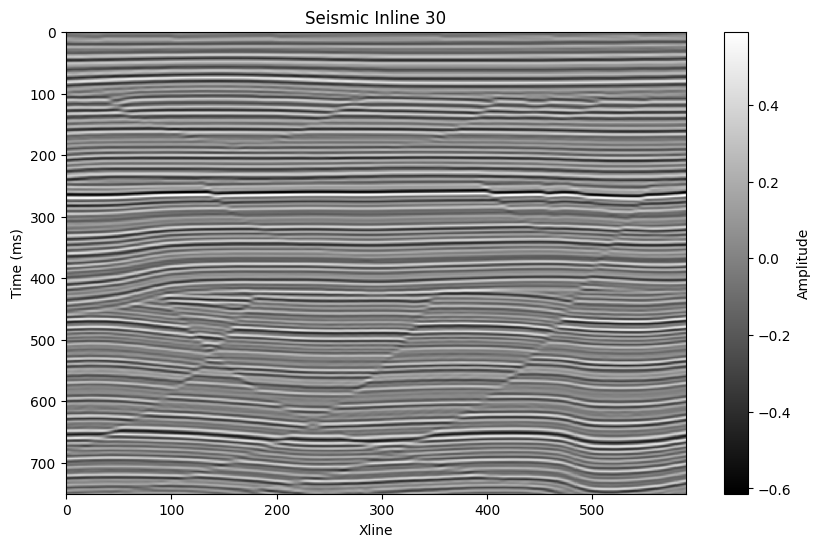

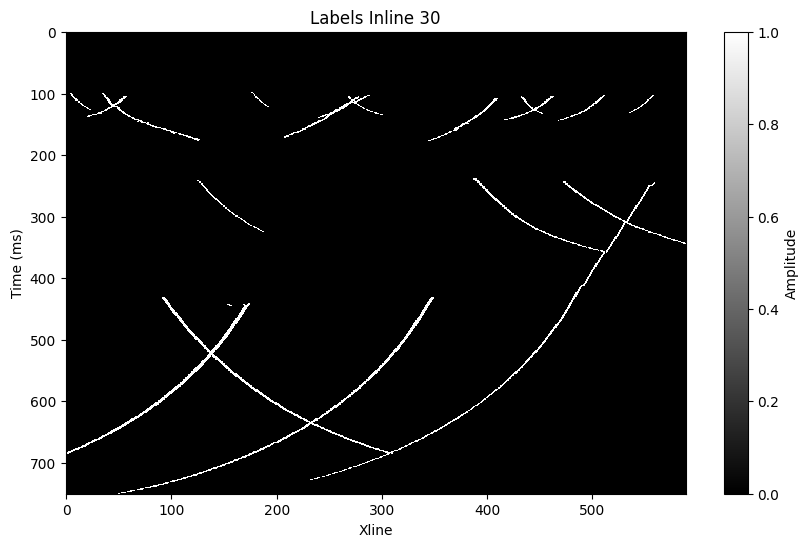

In [101]:
line = 30
plotseismic(seismic_vol, line,'Seismic')
plotseismic(label_vol, line,'Labels')

Next, I'm going to split the data in two subvolumnes for training and testing based on the xline range. The total number of xlines is 589, the training datraset will be a subvolume between the first and 400 xline, and the testing dataset between the 401 and the last xline.

In [10]:
train_seismic = seismic_vol[:, :400, :]
test_seismic = seismic_vol[:, 400:, :]

train_labels = label_vol[:, :400, :]
test_labels = label_vol[:, 400:, :]

print(f'Train size: {train_labels.shape}')
print(f'Test size: {test_labels.shape}')

Train size: (101, 400, 751)
Test size: (101, 189, 751)


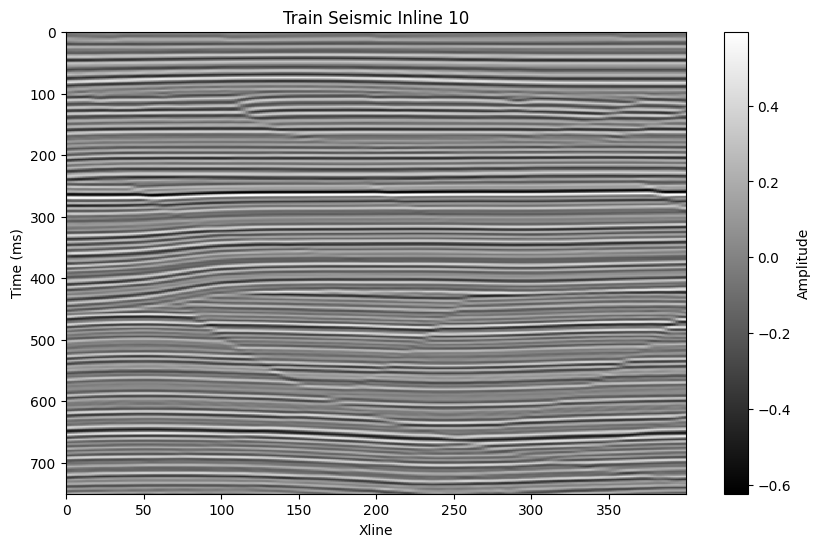

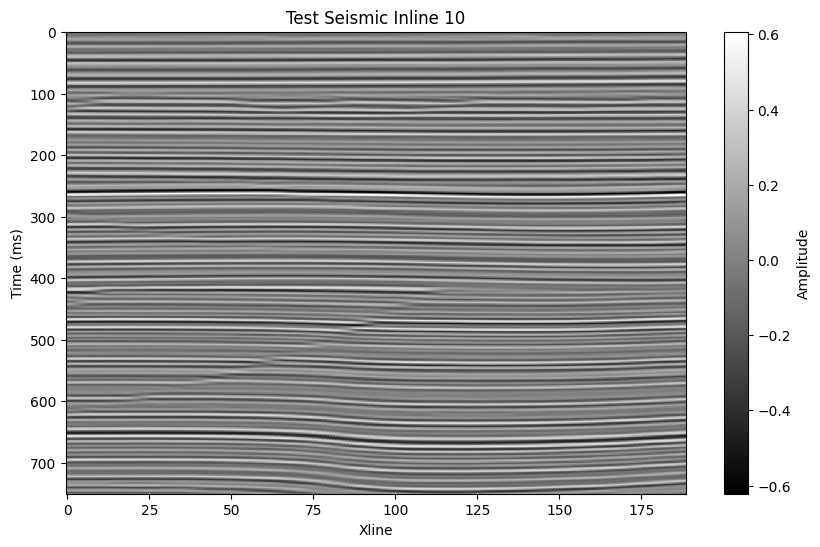

In [93]:
plotseismic(train_seismic, 10, 'Train Seismic')
plotseismic(test_seismic, 10,'Test Seismic')

## Model creation

For this project I create using PyTorch, this model use a convolutional neural network

To train the model, I created a class SEGYDataset to extract 3D patches from the volume. I'm going to use 1000 patches, and these are going to be normalized before training.

Then, I'm going to implement an U-Net architecture for binary segmentation.

For the last step, I'm going to train the network using BCELoss, which is used for binay classification, and Adam for optimization.


In [11]:
class SEGYDataset(Dataset):

    def __init__(self, seismic_vol, label_vol, patch_size=(64,64,64)):
        self.vol = seismic_vol
        self.labels = label_vol
        self.patch_size = patch_size
        self.d, self.h, self.w = seismic_vol.shape

    def __len__(self):
        return 1000

    def __getitem__(self, idx):
        dz, dy, dx = self.patch_size
        z = np.random.randint(0, self.d - dz)
        y = np.random.randint(0, self.h - dy)
        x = np.random.randint(0, self.w - dx)

        seismic_patch = self.vol[z:z+dz, y:y+dy, x:x+dx]
        label_patch = self.labels[z:z+dz, y:y+dy, x:x+dx]

        seismic_patch = (seismic_patch - seismic_patch.mean()) / (seismic_patch.std() + 1e-6)

        seismic_patch = torch.from_numpy(seismic_patch).float().unsqueeze(0)
        label_patch = torch.from_numpy(label_patch).float().unsqueeze(0)

        return seismic_patch, label_patch

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [13]:
class UNet3D(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, features=[32, 64, 128, 256]):
        super().__init__()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Downsampling path
        self.downs = nn.ModuleList()
        for feature in features:
            self.downs.append(DoubleConv(in_ch, feature))
            in_ch = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Upsampling path
        self.ups = nn.ModuleList()
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        # Mask generation
        self.final_conv = nn.Conv3d(features[0], out_ch, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]

            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)

        return torch.sigmoid(self.final_conv(x))

In [14]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0.0
    for seismic, labels in loader:
        seismic, labels = seismic.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(seismic)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)


Now, I define the parameters and train the network

In [15]:
patch_size = (64, 64, 64)
batch_size = 2
num_epochs = 50
learning_rate = 1e-4

In [25]:
dataset = SEGYDataset(train_seismic, train_labels, patch_size)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
model = UNet3D(in_ch=1, out_ch=1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
for epoch in range(1, num_epochs+1):
  loss = train_epoch(model, loader, criterion, optimizer, device)
  print(f"Epoch {epoch}/{num_epochs} - Loss: {loss:.4f}")
  # Save the model every 10 epochs
  if epoch % 10 == 0:
    torch.save(model.state_dict(), f"unet3d_epoch_{epoch}.pth")

torch.save(model.state_dict(), "unet3d_final.pth")

Epoch 1/50 - Loss: 0.3572
Epoch 2/50 - Loss: 0.2118
Epoch 3/50 - Loss: 0.1390
Epoch 4/50 - Loss: 0.0961
Epoch 5/50 - Loss: 0.0701
Epoch 6/50 - Loss: 0.0520
Epoch 7/50 - Loss: 0.0400
Epoch 8/50 - Loss: 0.0317
Epoch 9/50 - Loss: 0.0268
Epoch 10/50 - Loss: 0.0226
Epoch 11/50 - Loss: 0.0197
Epoch 12/50 - Loss: 0.0186
Epoch 13/50 - Loss: 0.0165
Epoch 14/50 - Loss: 0.0151
Epoch 15/50 - Loss: 0.0138
Epoch 16/50 - Loss: 0.0137
Epoch 17/50 - Loss: 0.0124
Epoch 18/50 - Loss: 0.0124
Epoch 19/50 - Loss: 0.0121
Epoch 20/50 - Loss: 0.0117
Epoch 21/50 - Loss: 0.0111
Epoch 22/50 - Loss: 0.0111
Epoch 23/50 - Loss: 0.0096
Epoch 24/50 - Loss: 0.0110
Epoch 25/50 - Loss: 0.0093
Epoch 26/50 - Loss: 0.0099
Epoch 27/50 - Loss: 0.0099
Epoch 28/50 - Loss: 0.0085
Epoch 29/50 - Loss: 0.0087
Epoch 30/50 - Loss: 0.0092
Epoch 31/50 - Loss: 0.0086
Epoch 32/50 - Loss: 0.0091
Epoch 33/50 - Loss: 0.0083
Epoch 34/50 - Loss: 0.0085
Epoch 35/50 - Loss: 0.0086
Epoch 36/50 - Loss: 0.0077
Epoch 37/50 - Loss: 0.0087
Epoch 38/5

The next plot shows the Loss function from the training in the previous step, we can notice there was no much change beyong the 20 epoch

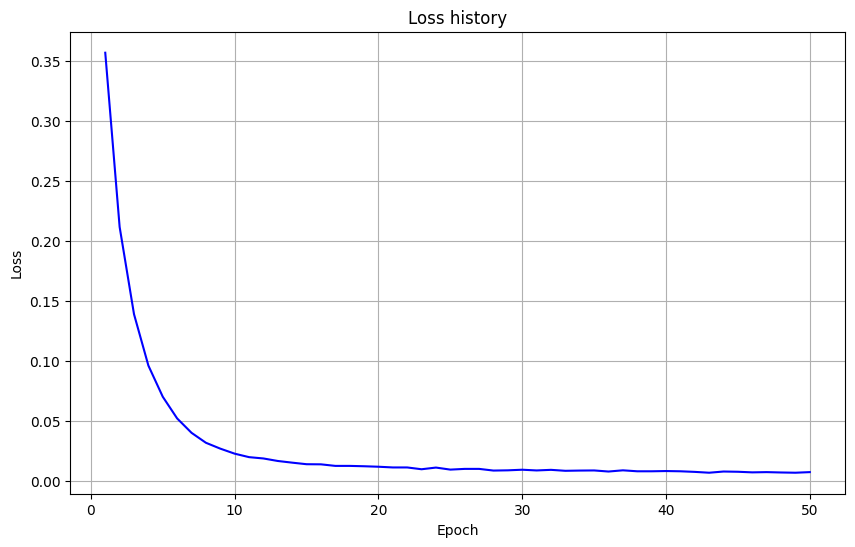

In [122]:
plt.figure(figsize=(10, 6))
plt.plot(losshistory['Epoch'], losshistory['Loss'], linestyle='-', color='b')
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Hyperparameter tunning
In this step, I'm going to optimize the hyperparameters, for this taks I'm going to calculate the Dice coefficient for image segmentation, between train and validation data.

First, I define two functions to evaluate the epoch and calculate the Dice coefficient, and then perform the hypermarameter search considering different patch size, batch size and learning rate. For this evalution a use only 5 epochs to make the process faster.

In [16]:
# Metrics Evaluation
def dice_coefficient(pred, target, eps=1e-6):
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + eps) / (pred_flat.sum() + target_flat.sum() + eps)

def evaluate_epoch(model, loader, device):
    model.eval()
    dices = []
    with torch.no_grad():
        for seismic, labels in loader:
            seismic, labels = seismic.to(device), labels.to(device)
            outputs = model(seismic)
            preds = (outputs > 0.5).float()
            dices.append(dice_coefficient(preds, labels).item())
    return np.mean(dices)

In [17]:
def hyperparameter_search(configs, seismic_vol, label_vol, device):
    best_cfg, best_dice = None, 0
    for cfg in configs:
        print(f"Evaluating config: {cfg}")
        dataset = SEGYDataset(seismic_vol, label_vol, patch_size=cfg['patch_size'])
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_ds, val_ds = random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_ds, batch_size=cfg['batch_size'], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=cfg['batch_size'], shuffle=False)
        model0 = UNet3D(in_ch=1, out_ch=1).to(device)
        optimizer = optim.Adam(model0.parameters(), lr=cfg['lr'])
        criterion = nn.BCELoss()
        for epoch in range(1, cfg['epochs']+1):
            train_epoch(model0, train_loader, criterion, optimizer, device)
        val_dice = evaluate_epoch(model0, val_loader, device)
        print(f"Validation Dice: {val_dice:.4f}")
        if val_dice > best_dice:
            best_dice, best_cfg = val_dice, cfg
    print(f"Best configuración: {best_cfg} with Dice={best_dice:.4f}")
    return best_cfg

In [18]:
# Configurations to test
configs = [
        {'patch_size': (64,64,64), 'batch_size': 2, 'lr': 1e-4, 'epochs': 5},
        {'patch_size': (64,64,64), 'batch_size': 4, 'lr': 1e-4, 'epochs': 5},
        {'patch_size': (64,64,64), 'batch_size': 2, 'lr': 5e-5, 'epochs': 5},
        {'patch_size': (64,64,64), 'batch_size': 4, 'lr': 5e-5, 'epochs': 5},
        {'patch_size': (32,32,32), 'batch_size': 4, 'lr': 1e-4, 'epochs': 5}
]

In [23]:
best = hyperparameter_search(configs, seismic_vol, label_vol, device)

Evaluating config: {'patch_size': (64, 64, 64), 'batch_size': 2, 'lr': 0.0001, 'epochs': 5}
Validation Dice: 0.1077
Evaluating config: {'patch_size': (64, 64, 64), 'batch_size': 4, 'lr': 0.0001, 'epochs': 5}
Validation Dice: 0.0000
Evaluating config: {'patch_size': (64, 64, 64), 'batch_size': 2, 'lr': 5e-05, 'epochs': 5}
Validation Dice: 0.0600
Evaluating config: {'patch_size': (64, 64, 64), 'batch_size': 4, 'lr': 5e-05, 'epochs': 5}
Validation Dice: 0.1923
Evaluating config: {'patch_size': (32, 32, 32), 'batch_size': 4, 'lr': 0.0001, 'epochs': 5}
Validation Dice: 0.1844
Best configuración: {'patch_size': (64, 64, 64), 'batch_size': 4, 'lr': 5e-05, 'epochs': 5} with Dice=0.1923


# Result and Analysis
To analyze the performance of the network, I use the testing set that create at the beginning.
First, I defined a function to calculate the Dice, the result was 0.54, which is a value good enough for this problem.


In [33]:
 def evaluate_on_volume(model, test_vol, test_lbl, patch_size,batch_size, device):

    test_dataset = SEGYDataset(test_vol, test_lbl,
                               patch_size=patch_size)
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)
    model.eval()
    dice = evaluate_epoch(model, test_loader, device)
    print(f"Dice for test: {dice:.2f}")
    return dice

In [34]:
evaluate_on_volume(model, test_seismic, test_labels, patch_size,batch_size, device)

Dice for test: 0.53


np.float64(0.5264726678987964)

To perform a visual analysis, now I define a function to generate a volume with the predicted labels

In [46]:
def predict_entire_volume(model, vol, device):
    vol_norm = (vol - vol.mean()) / (vol.std() + 1e-6)
    tensor = torch.from_numpy(vol_norm).float().unsqueeze(0).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad(): pred = model(tensor)
    return pred.squeeze().cpu().numpy()

In [47]:
pred_vol = predict_entire_volume(model, test_seismic, device)

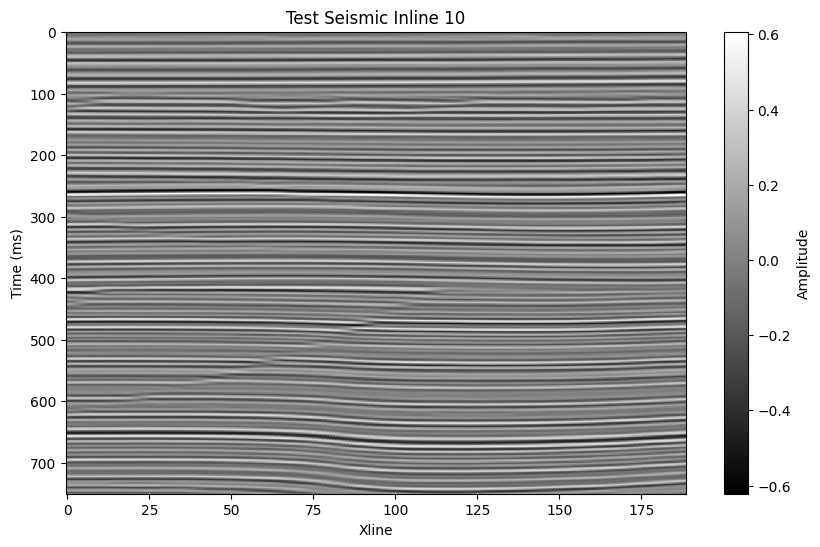

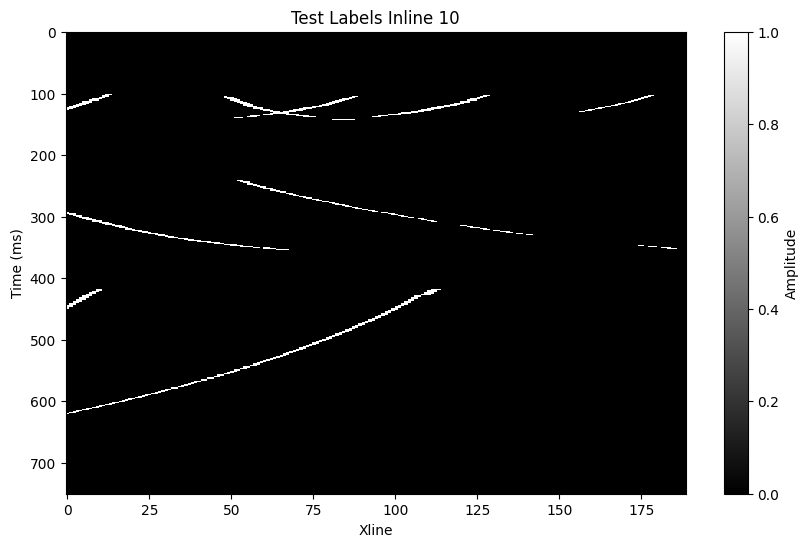

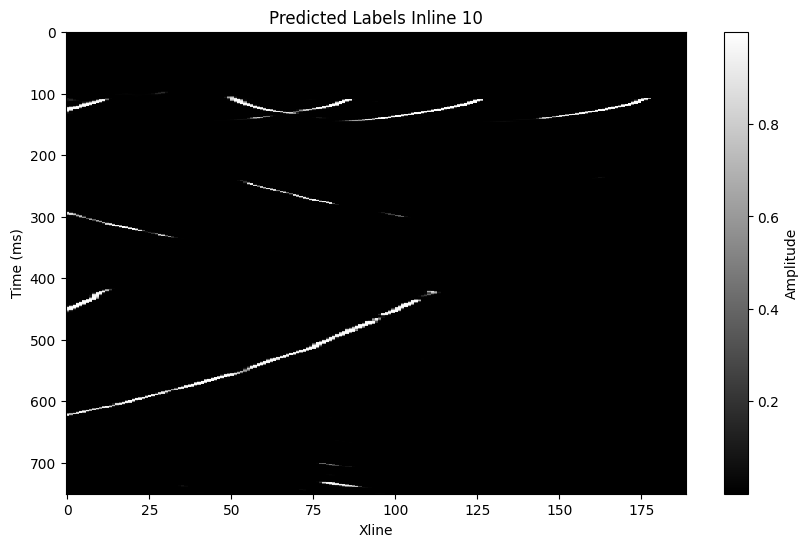

In [108]:
line = 10
plotseismic(test_seismic, line, 'Test Seismic')
plotseismic(test_labels, line,  'Test Labels')
plotseismic(pred_vol, line,  'Predicted Labels')

## Conclusions
* For this project I use a convolutional neural network using a U-Net architecture, to interpret faults from seismic data.
* The performance of the network was measure based on the Dice coefficient, between predicted and actual labels.
* Results are good enough to consider this as an effective approach to reduce the time required for a seismic interpretation.
* A future work could be extend the training of this CNN to include patches from other seismic volumes with a different geological configuration and signal to noise ratios.
